# Mounting G-Drive
We mount the google drive to fetch the required files to be processed.

In [ ]:
!pip install simpleitk

from google.colab import drive
drive.mount('/content/gdive')



     |████████████████████████████████| 48.4 MB 16 kB/s 
Mounted at /content/gdive


In [ ]:
import sys
sys.path.append('/content/gdive/My Drive/project')
%cd gdive/My Drive/project
!pwd

/content/gdive/My Drive/project
/content/gdive/My Drive/project


# Importing Libraries

In [ ]:
%matplotlib notebook
%matplotlib inline
import SimpleITK as sitk
import pandas as pd
import matplotlib.pyplot as plt
import gui

Reading the bacteria.mha image volume and displaying one sample slice of it.

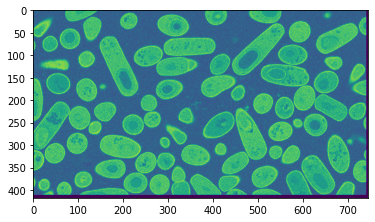

In [ ]:
bacteria = sitk.ReadImage("bacteria.mha")
z=10
slice=sitk.GetArrayViewFromImage(bacteria)[z,:,:]
plt.imshow(slice)

In order to get the insight of the various intensities of pixels in the image, we plot a histogram of the image and observe the plot.


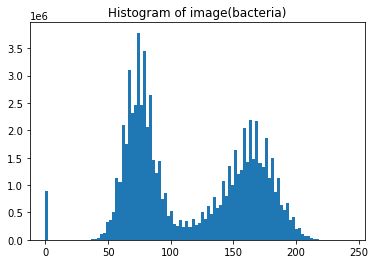

In [ ]:
plt.figure()
plt.hist(sitk.GetArrayViewFromImage(bacteria).flatten(), bins=100)
plt.title('Histogram of image(bacteria)')
plt.show()

Upon observing the histogram plot, we see that there are two peaks, one corresponds to bacteria and other to the background, so by using simple Otsu threshold filter it is possible to separate bacteria from background.

In [ ]:
from SimpleITK.SimpleITK import OtsuThresholdImageFilter
threshold_filter = sitk.OtsuThresholdImageFilter()


Creating a filter.


In [ ]:
thresh_filter = threshold_filter
thresh_filter.SetInsideValue(0)
thresh_filter.SetOutsideValue(1)
thresh_bacteria = thresh_filter.Execute(bacteria)
thresh_value = thresh_filter.GetThreshold()

thresh_bacteria = bacteria>thresh_value
print("Threshold used: " + str(thresh_value))




Applying filter on the bacteria image.

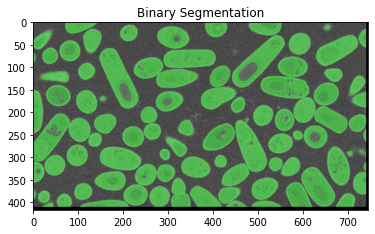

In [ ]:
binary_bacteria=sitk.LabelOverlay(bacteria, thresh_bacteria)

slice=sitk.GetArrayViewFromImage(binary_bacteria)[z,:,:]
plt.title('Binary Segmentation')
plt.imshow(slice)


Labelling all possible bacteria in image.

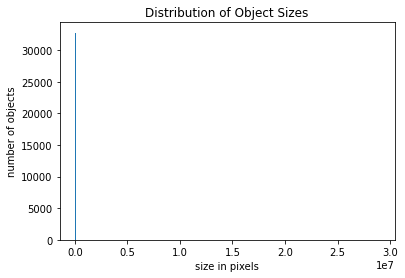

In [ ]:
stats = sitk.LabelShapeStatisticsImageFilter()
stats.Execute(sitk.ConnectedComponent(thresh_bacteria))

# Look at the distribution of sizes of connected components (bacteria).
label_sizes = [ stats.GetNumberOfPixels(l) for l in stats.GetLabels() if l != 1]

plt.figure()
plt.hist(label_sizes,bins=200)
plt.title("Distribution of Object Sizes")
plt.xlabel("size in pixels")
plt.ylabel("number of objects")
plt.show()

From the above histogram, we observe that there are numerous small pixels which have been considered as bacteria, se we need to remove them using Binary Opening by Reconstruction.

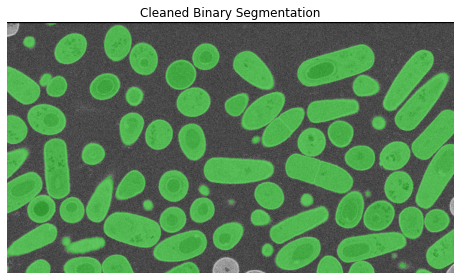

In [ ]:
cleaned_thresh_bacteria = sitk.BinaryOpeningByReconstruction(thresh_bacteria, [10, 10, 10])
cleaned_thresh_bacteria = sitk.BinaryClosingByReconstruction(cleaned_thresh_bacteria, [10, 10, 10])

cleaned_binary_bacteria = sitk.LabelOverlay(bacteria, cleaned_thresh_bacteria)


gui.MultiImageDisplay(image_list = [sitk.LabelOverlay(bacteria, cleaned_thresh_bacteria)],
                      title_list = ['Cleaned Binary Segmentation'], figure_size=(8,4));

Now, verifying if all the small incorrectly labeled bacteria are removed.

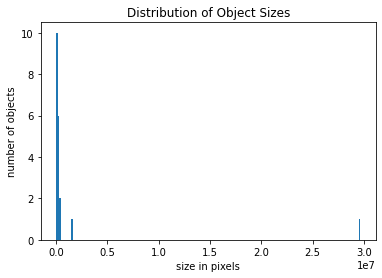

In [ ]:
stats = sitk.LabelShapeStatisticsImageFilter()
stats.Execute(sitk.ConnectedComponent(cleaned_thresh_bacteria))

# Look at the distribution of sizes of connected components (bacteria).
label_sizes = [ stats.GetNumberOfPixels(l) for l in stats.GetLabels() if l != 1]

plt.figure()
plt.hist(label_sizes,bins=200)
plt.title("Distribution of Object Sizes")
plt.xlabel("size in pixels")
plt.ylabel("number of objects")
plt.show()

The observation seems good now, but let us verify it visually by plotting the labelled bacteria.

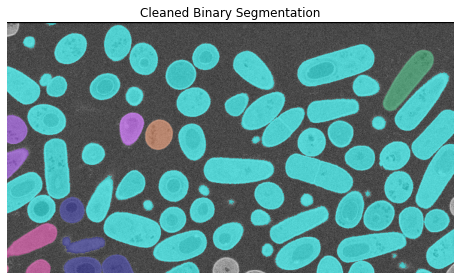

In [ ]:
gui.MultiImageDisplay(image_list = [sitk.LabelOverlay(bacteria, sitk.ConnectedComponent(cleaned_thresh_bacteria))],
                      title_list = ['Cleaned Binary Segmentation'],figure_size=(8,4));

# Watershed Segmentation
Bacteria is now separated from its background nicely, but we also need to separate it from each other. We will use classic segmentation algorithm known as watershed segmentation which will be suitable for problem in hand, since the image we are dealing with is not very complex to segment.

In [ ]:
dist_img = sitk.SignedMaurerDistanceMap(cleaned_thresh_bacteria != 0, insideIsPositive=False, squaredDistance=False, useImageSpacing=False)
radius = 10
# Seeds have a distance of "radius" or more to the object boundary, they are uniquely labelled.
seeds = sitk.ConnectedComponent(dist_img < -radius)
# Relabel the seed objects using consecutive object labels while removing all objects with less than 15 pixels.
seeds = sitk.RelabelComponent(seeds, minimumObjectSize=15)
# Run the watershed segmentation using the distance map and seeds.
ws = sitk.MorphologicalWatershedFromMarkers(dist_img, seeds, markWatershedLine=True)
ws = sitk.Mask( ws, sitk.Cast(cleaned_thresh_bacteria, ws.GetPixelID()))

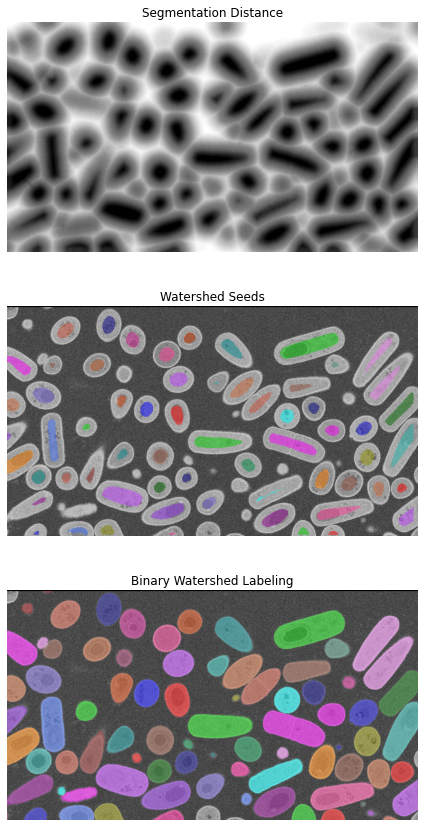

In [ ]:
gui.MultiImageDisplay(image_list = [dist_img,sitk.LabelOverlay(bacteria, seeds),sitk.LabelOverlay(bacteria, ws)],
                      title_list = ['Segmentation Distance','Watershed Seeds','Binary Watershed Labeling'],
                      shared_slider=True,horizontal=False,figure_size=(6,12));

# Removing Objects touching Boundary
Since it is not clear whether the objects touching the image boundary are whole bacteria, so we remove them.

In [ ]:
# The image has a small black border which we account for here.
bgp = sitk.BinaryGrindPeak( (ws!=0)| (bacteria==0))
non_border_seg = sitk.Mask( ws, bgp==0)

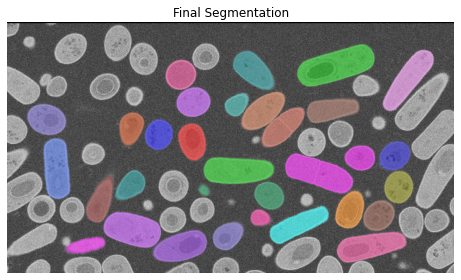

In [ ]:
gui.MultiImageDisplay(image_list = [sitk.LabelOverlay(bacteria, non_border_seg)],
                      title_list = ['Final Segmentation'],figure_size=(8,4));

# Computation of the features from 3D segmented objects
Hereby, we compute the desired features of the segmented bacteria : volume (nm^3),elongation, size of oriented bounding box in nm, Intensity Mean and Standard Deviation, Intensity Skewness


In [ ]:
shape_stats = sitk.LabelShapeStatisticsImageFilter()
shape_stats.ComputeOrientedBoundingBoxOn()
shape_stats.Execute(non_border_seg)

intensity_stats = sitk.LabelIntensityStatisticsImageFilter()
intensity_stats.Execute(non_border_seg,bacteria)

In [ ]:
stats_list = [ (shape_stats.GetPhysicalSize(i),
               shape_stats.GetElongation(i),
               shape_stats.GetOrientedBoundingBoxSize(i)[0],
               shape_stats.GetOrientedBoundingBoxSize(i)[2],
               intensity_stats.GetMean(i),
               intensity_stats.GetStandardDeviation(i),
               intensity_stats.GetSkewness(i)) for i in shape_stats.GetLabels()]
cols=["Volume (nm^3)",
      "Elongation",
      "Oriented Bounding Box Minimum Size(nm)",
      "Oriented Bounding Box Maximum Size(nm)",
     "Intensity Mean",
     "Intensity Standard Deviation",
     "Intensity Skewness"]

# Create the pandas data frame and display descriptive statistics.
stats = pd.DataFrame(data=stats_list, index=shape_stats.GetLabels(), columns=cols)
stats.describe()

,Volume (nm^3),Elongation,Oriented Bounding Box Minimum Size(nm),Oriented Bounding Box Maximum Size(nm),Intensity Mean,Intensity Standard Deviation,Intensity Skewness
count,3.900000e+01,39.000000,39.000000,39.000000,39.000000,39.000000,39.000000
mean,1.326484e+09,2.524763,950.318662,2363.761955,162.123265,18.629765,-0.186030
std,2.513447e+08,0.388322,67.614313,328.801945,6.069175,1.854534,0.337011
min,7.807060e+08,1.896962,821.148163,1740.946207,145.989312,15.695578,-0.784848
25%,1.169896e+09,2.197961,921.490360,2138.411450,156.489511,16.846459,-0.438251
50%,1.350960e+09,2.509284,959.145783,2319.711131,164.231786,18.657140,-0.253150
75%,1.479031e+09,2.771791,1000.923878,2619.326454,166.388145,19.571387,0.009920
max,1.876773e+09,3.422789,1103.117728,3063.515049,171.616615,23.393861,0.656684


In [ ]:
bacteria.GetSize()

(746, 418, 238)

#References

[1]  http://insightsoftwareconsortium.github.io/SimpleITK-Notebooks/Python_html/35_Segmentation_Shape_Analysis.html

[2]  https://www.upgrad.com/blog/image-segmentation-techniques/

